In [171]:
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

Let's now get to modelling! We will be trying 3 models: 
- Logistic Regression - 
- Decision Tree Classifier - 
- Histogram Gradient Boosting Classifier - 

Let's look at our data now:

In [2]:
df= pd.read_csv('Data/modelling_df.csv',index_col=0)

In [6]:
df.shape

(277003, 15)

In [7]:
df

,Climate ID,geometry_x,YEAR,MONTH,fire_index,distance,geometry_y,Longitude (x),Latitude (y),Date,Mean Temp (°C),Total Snow (cm),Total Precip (mm),geometry,Fire
0,1012055,NaN,1990,1,NaN,NaN,NaN,-124.05,48.83,1990-01-31,3.665517,1.225806,11.906452,POINT (-124.05 48.83),0
1,1012710,NaN,1990,1,NaN,NaN,NaN,-123.44,48.43,1990-01-31,NaN,0.032258,6.870968,POINT (-123.44 48.43),0
2,1015105,NaN,1990,1,NaN,NaN,NaN,-123.56,48.37,1990-01-31,NaN,0.064516,7.245161,POINT (-123.56 48.37),0
3,1015628,NaN,1990,1,NaN,NaN,NaN,-123.72,48.82,1990-01-31,NaN,0.596774,7.180645,POINT (-123.72 48.82),0
4,1015638,NaN,1990,1,NaN,NaN,NaN,-123.29,48.76,1990-01-31,NaN,0.225806,5.103226,POINT (-123.29 48.76),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276998,8402520,NaN,2022,12,NaN,NaN,NaN,-55.67,49.92,2022-12-31,-2.470968,NaN,2.677419,POINT (-55.67 49.92),0
276999,8402544,NaN,2022,12,NaN,NaN,NaN,-53.90,48.35,2022-12-31,0.413793,0.137931,4.482759,POINT (-53.9 48.35),0
277000,8501900,NaN,2022,12,NaN,NaN,NaN,-60.42,53.32,2022-12-31,-7.009677,0.593548,0.580645,POINT (-60.42 53.32),0
277001,8502400,NaN,2022,12,NaN,NaN,NaN,-60.22,55.45,2022-12-31,-4.612000,NaN,2.666667,POINT (-60.22 55.45),0


Let's clean up the data to get it ready for modelling. We will be dropping the following columns: 
- geometry - we don't need to know where the fire is located, just that a fire has occurred
- Climate ID - We don't need to know the Station ID 
- geometry_x - we don't need to know where the fire is located, just that a fire has occurred
- geometry_y - we don't need to know where the fire is located, just that a fire has occurred
- fire_index - we don't need to know the index of the fire data
- distance- we don't need the distance anymore
- Date - We already have the YEAR and MONTH Column, so we don't need the date. 

In [8]:
df.drop(columns=['geometry','Climate ID','geometry_x','geometry_y','fire_index','distance','Date'],inplace=True)

In [16]:
df.head()

,YEAR,MONTH,Longitude (x),Latitude (y),Mean Temp (°C),Total Snow (cm),Total Precip (mm),Fire
0,1990,1,-124.05,48.83,3.665517,1.225806,11.906452,0
1,1990,1,-123.44,48.43,NaN,0.032258,6.870968,0
2,1990,1,-123.56,48.37,NaN,0.064516,7.245161,0
3,1990,1,-123.72,48.82,NaN,0.596774,7.180645,0
4,1990,1,-123.29,48.76,NaN,0.225806,5.103226,0


Let's now look at the ratio of missing data per column and see what comes up:

In [17]:
for i in range(len(df.columns)):
    na_index=df.isna().sum().index[i]
    na_ratio=df.isna().sum().iloc[i]
    print(f'{na_index} has {round((na_ratio/df.shape[0])*100,2)}% missing data')

YEAR has 0.0% missing data
MONTH has 0.0% missing data
Longitude (x) has 1.61% missing data
Latitude (y) has 1.61% missing data
Mean Temp (°C) has 15.27% missing data
Total Snow (cm) has 21.93% missing data
Total Precip (mm) has 8.92% missing data
Fire has 0.0% missing data


Now let's separate the X and y variables. We'll be shifting the X variables down 12 rows to allow the model to predict 12 months into the future.

In [103]:
X = df.loc[:,df.columns != 'Fire']
X = X.shift(periods=12)


In [104]:
X.drop(X.index[0:12],inplace=True)

In [105]:
X

,YEAR,MONTH,Longitude (x),Latitude (y),Mean Temp (°C),Total Snow (cm),Total Precip (mm)
12,1990.0,1.0,-124.05,48.83,3.665517,1.225806,11.906452
13,1990.0,1.0,-123.44,48.43,NaN,0.032258,6.870968
14,1990.0,1.0,-123.56,48.37,NaN,0.064516,7.245161
15,1990.0,1.0,-123.72,48.82,NaN,0.596774,7.180645
16,1990.0,1.0,-123.29,48.76,NaN,0.225806,5.103226
...,...,...,...,...,...,...,...
276998,2022.0,12.0,-64.92,44.98,0.996774,0.651613,3.903226
276999,2022.0,12.0,-63.83,44.77,-0.321739,0.173913,4.956522
277000,2022.0,12.0,-64.65,45.05,1.067742,0.064516,3.319355
277001,2022.0,12.0,-64.66,43.99,2.487097,NaN,4.300000


Let's now drop the last 12 rows from the y variable, this is to ensure that both X and y have the same number of rows. 

In [106]:
y=df.loc[:,'Fire']
y.drop(df.tail(12).index,inplace=True)

### Using Logistic Regression for modelling

For logistic regression to work, we will need to do something about our null values. Since the null values are spread across different features, let's try to impute them using IterativeImputer. It's still in beta, but this imputer takes into account all the other features accross a row to impute a value. This should help address the changes in some of our values throughout the months (i.e `snow coverage(S_G)`, `mean Temperature(TM)`)

In [146]:
# We need to explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer 
# Now we can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

In [147]:
iter_imputer=IterativeImputer(max_iter=10000)


In [148]:
iter_imputer.fit(X)

IterativeImputer(max_iter=10000)

In [149]:
X_transformed_array=iter_imputer.transform(X)

In [150]:
X_transformed=pd.DataFrame(X_transformed_array,columns=X.columns,index=X.index)

In [151]:
X_transformed.isna().sum()

YEAR                 0
MONTH                0
Longitude (x)        0
Latitude (y)         0
Mean Temp (°C)       0
Total Snow (cm)      0
Total Precip (mm)    0
dtype: int64

Perfect, looks like we imputed all the missing data. Let's see if our logistic regression will be able to predict fires. Let's upsample the positive fire data again to remove any imbalance. 

In [152]:
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(X_transformed, y, test_size=0.2, random_state=50)

# X_upsampled, y_upsampled = resample(X_train[y_train == 1],
#                                     y_train[y_train == 1],
#                                     replace=True,
#                                     n_samples=X_train[y_train == 0].shape[0],
#                                     random_state=10)
# # Combine upsample with original data
# X_train_bal_logit = np.vstack((X_train[y_train == 0], X_upsampled))
# y_train_bal_logit= np.hstack((y_train[y_train == 0], y_upsampled))

# # Convert the X variable numpy array into a dataframe
# X_train_bal_logit = pd.DataFrame(X_train_bal_logit, columns=X.columns)


Let's scale our Train data now before running the logistic regression

In [153]:
from sklearn.preprocessing import StandardScaler


In [155]:
scaler=StandardScaler()
scaler=scaler.fit(X_train_logit)
X_train_ss=scaler.transform(X_train_logit)

In [ ]:
X_train_ss_logit=pd.DataFrame(X_train_ss,columns=X_train_logit.columns)

Let's start our logistic regression now: 

In [ ]:
logreg= LogisticRegression()
logit=logreg.fit(X_train_ss_logit,y_train_logit)

Let's look at the train score for our logistic regression now: 

In [ ]:
logit.score(X_train_ss_logit,y_train_logit)

0.7953130076898083

In [ ]:
X_test_ss= scaler.transform(X_test_logit)

In [ ]:
X_test_ss_logit=pd.DataFrame(X_test_ss,columns=X_test_logit.columns)

And let's look out our test score:

In [ ]:
logit.score(X_test_ss_logit,y_test_logit)

0.7953753677864221

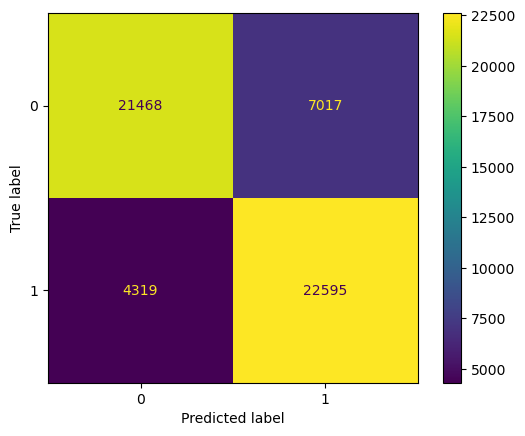

In [ ]:
ConfusionMatrixDisplay.from_estimator(logit,X_test_ss_logit,y_test_logit)

In [ ]:
coef_df = pd.DataFrame(logit.coef_ ,columns=X.columns)

In [ ]:
coef_df.head()

,YEAR,MONTH,Longitude (x),Latitude (y),Mean Temp (°C),Total Snow (cm),Total Precip (mm)
0,0.368625,-0.697813,-0.475209,0.113933,2.143118,-0.058009,-0.579147


#### Conclusion

It looks like our logistic regression gave us a score of 79% for both train and test, which is not terrible. We can see from our confusion matrix that it did a decent job at predicting both positive and negative occurances of fires. Let's see if we can increase the precision with other models. 

### Using Decision Tree Classifier for modelling

Let's now take a look at a decision tree model to see if we would get better results. We'll use the `X_transformed` variables from above since we need to impute the missing values. 

In [161]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [162]:
dt=DecisionTreeClassifier()

In [163]:
dt.fit(X_train_dt,y_train_dt)

DecisionTreeClassifier()

In [164]:
print(f"The TRAIN classification accuracy is:  {dt.score(X_train_dt,y_train_dt)}")
print(f"The TEST classification accuracy is:  {dt.score(X_test_dt,y_test_dt)}")

The TRAIN classification accuracy is:  1.0
The TEST classification accuracy is:  0.9652159786277731


This looks very much like an overfitted model, let's see how we can make it more generalized. We'll be running a loop to see the ideal depth that our model needs. First, we'll need to reset our train/test to avoid data leakage:

In [165]:
X_train_dt2, X_test_dt2, y_train_dt2, y_test_dt2 = train_test_split(X_transformed, y, test_size=0.2, random_state=24)

In [168]:
train_acc = []
test_acc = []

for depth in range(1,30):
    
    dt_model = DecisionTreeClassifier(max_depth=depth)
    
    dt_model.fit(X_train_dt2, y_train_dt2)
    
    train_acc.append(dt_model.score(X_train_dt2, y_train_dt2))
    test_acc.append(dt_model.score(X_test_dt2, y_test_dt2))
    
    
    print(f'Max depth: {depth}---train acc {train_acc[depth-1]}---test acc {test_acc[depth-1]}')

Max depth: 1---train acc 0.7413715296581104---test acc 0.7397064928969836
Max depth: 2---train acc 0.8189329939709015---test acc 0.8201772595173198
Max depth: 3---train acc 0.8392405863027547---test acc 0.8391487210960487
Max depth: 4---train acc 0.8684113144878877---test acc 0.8706113828769473
Max depth: 5---train acc 0.8976452218491642---test acc 0.8998176862398238
Max depth: 6---train acc 0.9186161955305245---test acc 0.9198902507265474
Max depth: 7---train acc 0.9254756489403949---test acc 0.9262441560316973
Max depth: 8---train acc 0.9332827899924185---test acc 0.9317316197043268
Max depth: 9---train acc 0.940124192209105---test acc 0.9381938302135417
Max depth: 10---train acc 0.9461442651359255---test acc 0.942832903120995
Max depth: 11---train acc 0.9528773601935088---test acc 0.9479412985793967
Max depth: 12---train acc 0.9576925159753059---test acc 0.950215707864763
Max depth: 13---train acc 0.9623497238167443---test acc 0.9525262188848174
Max depth: 14---train acc 0.968017798

Let's now plot the results:

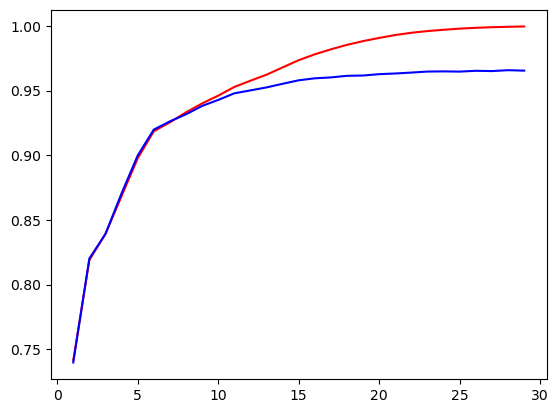

In [169]:
plt.figure()

plt.plot(range(1,30), train_acc, label = 'train', c = 'r')
plt.plot(range(1,30), test_acc, label = 'test', c = 'b')

plt.show()

Based on the results above, we're willing to accept that a max depth of 3 is ideal, even though we get an accuracy of ~84%. We're accepting it because both the train and test scores are very close to one another at 0.8392405863027547 for train and 0.8391487210960487 for test. Let's try it again and take a look at the decision tree:

In [172]:
X_train_dt3, X_test_dt3, y_train_dt3, y_test_dt3 = train_test_split(X_transformed, y, test_size=0.2, random_state=10)

In [174]:
dt_final=DecisionTreeClassifier(max_depth=3)
dt_final.fit(X_train_dt3,y_train_dt3)

DecisionTreeClassifier(max_depth=3)

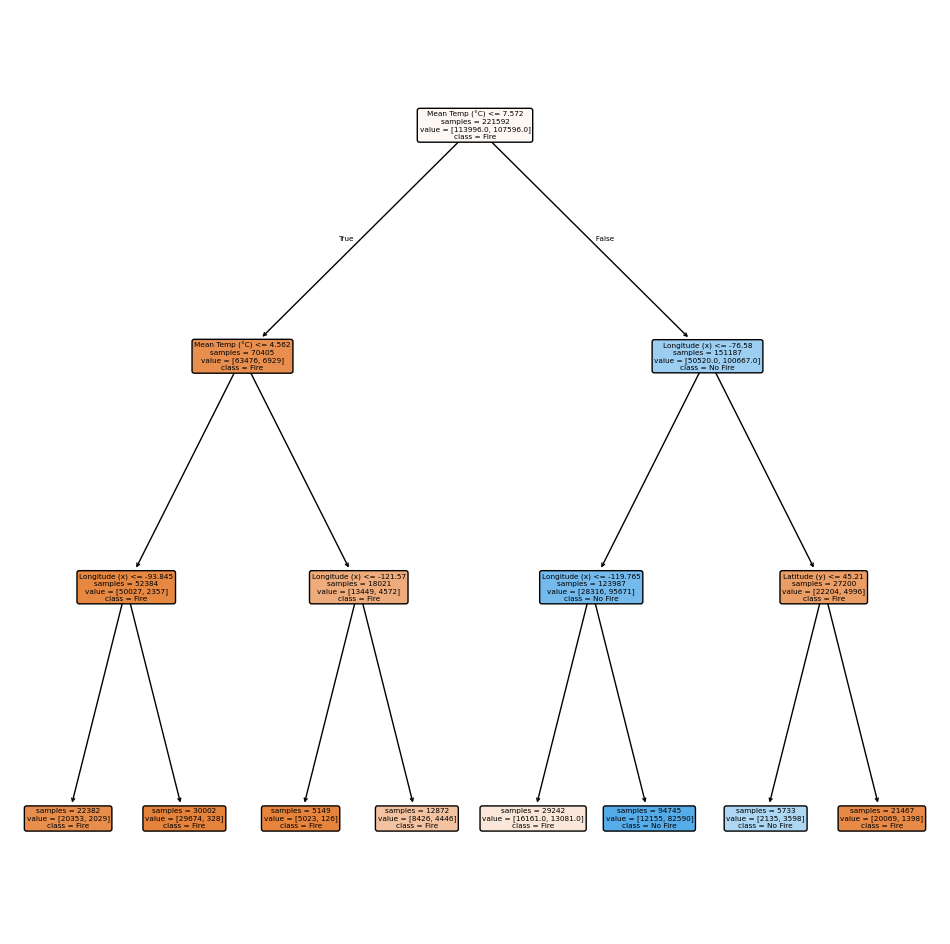

In [176]:
plt.figure(figsize=(12,12))
plot_tree(dt_final, 
          feature_names=list(X_transformed.columns), 
          class_names=['Fire','No Fire'],
          rounded=True,
          impurity=False,
          filled=True, );
plt.show()

#### Conclusion 

A Decision tree classifier gave us a decent result. We can see that the feature at the top of the decision tree is the mean temperature, which is in line with our logisitic regression as being the feature with the most correlation with increasing the likelyhood of a fire occuring. 

In [177]:
print(f"The TRAIN classification accuracy is:  {dt_final.score(X_train_dt3,y_train_dt3)}")
print(f"The TEST classification accuracy is:  {dt_final.score(X_test_dt3,y_test_dt3)}")

The TRAIN classification accuracy is:  0.8389021264305571
The TEST classification accuracy is:  0.8405025361468619


### Using Histogram Gradient Boosting Classifier for modelling

I chose HistGradientBoostingClassifier for my first model because there are a lot of null values within my dataset that have not been imputed. The null values exist naturally in my dataset, as in even with new data there will be some metrics that get missed. I'll try to impute the missing information in my next model, where I will try a simple logistic regression. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [137]:
histboost=HistGradientBoostingClassifier()
histboost.fit(X_train,y_train)

HistGradientBoostingClassifier()

In [138]:
histboost.score(X_train,y_train)


0.9558242174807755

In [139]:
histboost.score(X_test,y_test)


0.9539883391396956

In [140]:
total_targets= y.value_counts()[0] +  y.value_counts()[1] 

In [141]:
y.value_counts()

Fire
0    142600
1    134391
Name: count, dtype: int64

In [142]:
y_predict= histboost.predict(X_test)

In [143]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

report_initial = classification_report(y_test, y_predict)


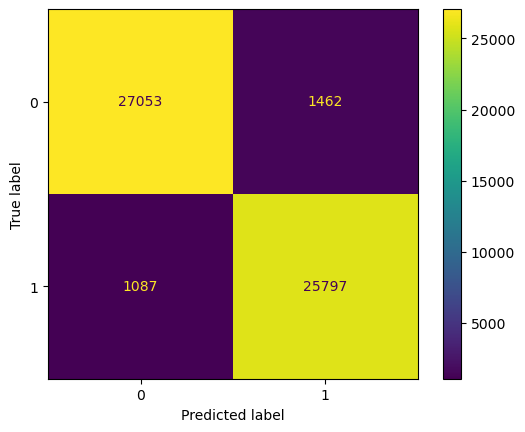

In [144]:
ConfusionMatrixDisplay.from_estimator(histboost,X_test,y_test)

In [145]:
print(histboost.get_params())

{'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_features': 1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [179]:
#precision calculation
25797/(25787+1087)

0.9599240901987051

#### Conculsion

The histogram Gradient Booster model is the model that gave us the best score, with a train score of 95.39% and a test score of 95.58%. The precision is also high with a total of 95.99%. I will be using this model as the main model of my capstone.

